In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=11)
plt.rc('legend', fontsize=11)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

# absolute path to ST modules
module_path = r'C:\Users\Jose Alvarez\Documents\Projects\CounterfactualSituationTesting\src'
# module_path = os.path.abspath(os.path.join('../src')) # or the path to your source code
sys.path.insert(0, module_path)
# local files
from src.situation_testing.situation_testing import SituationTesting

In [2]:
# change data path accordingly
data_path = os.getcwd() + '\\' + 'data' + '\\'
resu_path = os.getcwd() + '\\' + 'results' + '\\'

In [3]:
# factual dataset
org_df    = pd.read_csv(data_path + 'Karimi2020_v2.csv', sep='|', )
# counterfactual dataset
org_cf_df = pd.read_csv(resu_path + 'counterfactuals\\cf_Karimi2020_v2.csv', sep='|', )

### Set overall paremeters for test
We can run standard ST, counterfactual ST with/without the search centers, and counterfactual fairness. Notice that CF is included within cfST when incuding the search centers: these are th factual and counterfactual instances.

In [4]:
# attribute-specific params
feat_trgt = 'LoanApproval'
feat_trgt_vals = {'positive': 1, 'negative': -1}
# list of relevant features
feat_rlvt = ['AnnualSalary', 'AccountBalance']
# protected feature
feat_prot = 'Gender'
# values for the protected feature: use 'non_protected' and 'protected' accordingly
feat_prot_vals = {'non_protected': 0, 'protected': 1}

# st-specific params
# size of neiuborhoods
n = 15
# significance level
alpha = 0.05
# tau diviation
tau = 0.0

In [5]:
res_df = org_df[['Gender', 'LoanApproval']].copy()
res_df['cf_LoanApproval'] = org_cf_df['LoanApproval'].copy()
res_df.head(5)

,Gender,LoanApproval,cf_LoanApproval
0,1,-1.0,-1.0
1,0,1.0,1.0
2,0,-1.0,-1.0
3,0,-1.0,-1.0
4,1,1.0,1.0


From one of the CLeaR reviewers: what is your Oracle?
I guess, in this world, it would be a world freed from systematic bias, meaning counterfactual fairness captures this discrepancy between worlds, no?

The world where $X_1$ and $X_2$ are born without $A$'s influence is a counterfactually fair world by definition from Kusner et al.!!!

In [6]:
print(res_df[(res_df['Gender'] == 1) & (res_df['LoanApproval'] == 1)].shape[0])
# vs
print(res_df[(res_df['Gender'] == 1) & (res_df['cf_LoanApproval'] == 1)].shape[0]) #ground truthc (if you will)

674
1050


In [7]:
test_df = org_df.copy()

st = SituationTesting()
st.setup_baseline(test_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

res_df['ST'] = st.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1},
                      sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
                      k=n, alpha=alpha, tau=tau)

standardizing factual dataset


In [8]:
# get all neighborhoods for ST
stST_knn = st.res_dict_df_neighbors

In [9]:
test_df    = org_df.copy()
test_cf_df = org_cf_df.copy()

# don't include the centers
cf_st = SituationTesting()
cf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

res_df['cfST'] = cf_st.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1},
                           sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
                           include_centers=False,
                           k=n, alpha=alpha, tau=tau)

standardizing factual dataset
standardizing counterfactual dataset


In [11]:
# get all neighnorhoods for cfST
cfST_knn = cf_st.res_dict_df_neighbors

### stST vs cfST:

- look at the cfST without centers (to be able to compare them)
- look at the c's that are shared between both methods: look at the distribution of each's ctr and tst
    - also look at the factual vs counterfactuals: average distance among this set
- look at the c's that are NOT shared between both methods and do the same

In [12]:
# sets of interest

# c in stST and in stCF
set1 = res_df[(res_df['ST'] > tau) & (res_df['cfST'] > tau)].index.to_list()
print(len(set1))

# c not in stST but in stCF
set2 = [c for c in res_df[(res_df['cfST'] > tau)].index.to_list() if c not in set1]
print(len(set2))

55
233


[3164, 4607, 3071, 2083, 3308]


<AxesSubplot:xlabel='ID', ylabel='AccountBalance'>

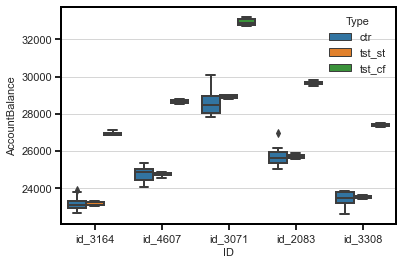

In [14]:
# let's look at those c's that appear both in stST and cfST
test_n = 5

test_c = random.sample(set2, test_n)
# test_c = random.sample(set2, test_n)
print(test_c)

var = ['AnnualSalary', 'AccountBalance']
temp_df_list = []

for c in test_c:
    
#     print('===== ===== =====')
    
#     print(stST_knn[c]['ctr_idx'])
    temp_ctr = org_df.iloc[stST_knn[c]['ctr_idx'], :][var].copy()
    temp_ctr['ID'] = 'id_' + str(c)
    temp_ctr['Type'] = 'ctr'
    temp_df_list.append(temp_ctr)
    del temp_ctr
    
#     print(stST_knn[c]['tst_idx'])
    temp_tst_st = org_df.iloc[stST_knn[c]['tst_idx'], :][var].copy()
    temp_tst_st['ID'] = 'id_' + str(c)
    temp_tst_st['Type'] = 'tst_st'
    temp_df_list.append(temp_tst_st)
    del temp_tst_st
    
#     print(cfST_knn[c]['tst_idx'])
    temp_tst_cf = org_cf_df.iloc[cfST_knn[c]['tst_idx'], :][var].copy()
    temp_tst_cf['ID'] = 'id_' + str(c)
    temp_tst_cf['Type'] = 'tst_cf'
    temp_df_list.append(temp_tst_cf)
    del temp_tst_cf
    
    

box_plot_data = pd.concat(temp_df_list)
del temp_df_list

# box_plot_data
sns.boxplot(x = box_plot_data['ID'],
            y = box_plot_data['AccountBalance'],
            hue = box_plot_data['Type'])

# todo: save var x set combination 

In [15]:
# Get summary stats
nsf = 1
list_temp_df = []
var = ['AnnualSalary', 'AccountBalance']

for c in set1:
    
    temp_df = {}
    temp_ctr    = org_df.iloc[stST_knn[c]['ctr_idx'], :][var]
    temp_tst_st = org_df.iloc[stST_knn[c]['tst_idx'], :][var]
    temp_tst_cf = org_cf_df.iloc[cfST_knn[c]['tst_idx'], :][var]
    
    temp_df['id'] = c
    for v in var:
        temp_df['avg_ctr_' + v] = round(temp_ctr.mean()[v], nsf)
        temp_df['std_ctr_' + v] = round(temp_ctr.std()[v], nsf)
        
        temp_df['avg_tst_st_' + v] = round(temp_tst_st.mean()[v], nsf)
        temp_df['std_tst_st_' + v] = round(temp_tst_st.std()[v], nsf)
        
        temp_df['avg_tst_cf_' + v] = round(temp_tst_cf.mean()[v], nsf)
        temp_df['std_tst_cf_' + v] = round(temp_tst_cf.std()[v], nsf)
    
    list_temp_df.append(temp_df)

set1_summary_stats = pd.DataFrame(list_temp_df)

set1_summary_stats['diff_ctr_tstST_AnnualSalary'] = set1_summary_stats['avg_ctr_AnnualSalary'] - set1_summary_stats['avg_tst_st_AnnualSalary']
set1_summary_stats['diff_ctr_tstCF_AnnualSalary'] = set1_summary_stats['avg_ctr_AnnualSalary'] - set1_summary_stats['avg_tst_cf_AnnualSalary']
set1_summary_stats['diff_btw_tst_AnnualSalary'] = set1_summary_stats['avg_tst_st_AnnualSalary'] - set1_summary_stats['avg_tst_cf_AnnualSalary']

set1_summary_stats['diff_ctr_tstST_AccountBalance'] = set1_summary_stats['avg_ctr_AccountBalance'] - set1_summary_stats['avg_tst_st_AccountBalance']
set1_summary_stats['diff_ctr_tstCF_AccountBalance'] = set1_summary_stats['avg_ctr_AccountBalance'] - set1_summary_stats['avg_tst_cf_AccountBalance']
set1_summary_stats['diff_btw_tst_AccountBalance'] = set1_summary_stats['avg_tst_st_AccountBalance'] - set1_summary_stats['avg_tst_cf_AccountBalance']

set1_summary_stats.head(5)

,id,avg_ctr_AnnualSalary,std_ctr_AnnualSalary,avg_tst_st_AnnualSalary,std_tst_st_AnnualSalary,avg_tst_cf_AnnualSalary,std_tst_cf_AnnualSalary,avg_ctr_AccountBalance,std_ctr_AccountBalance,avg_tst_st_AccountBalance,std_tst_st_AccountBalance,avg_tst_cf_AccountBalance,std_tst_cf_AccountBalance,diff_ctr_tstST_AnnualSalary,diff_ctr_tstCF_AnnualSalary,diff_btw_tst_AnnualSalary,diff_ctr_tstST_AccountBalance,diff_ctr_tstCF_AccountBalance,diff_btw_tst_AccountBalance
0,5,101866.7,2635.4,100000.0,0.0,110000.0,0.0,26179.2,896.8,25924.1,315.8,29959.0,211.1,1866.7,-8133.3,-10000.0,255.1,-3779.8,-4034.9
1,147,86733.3,1222.8,90000.0,0.0,100000.0,0.0,27708.7,520.7,27822.3,54.9,31842.3,104.8,-3266.7,-13266.7,-10000.0,-113.6,-4133.6,-4020.0
2,181,96000.0,1085.6,100000.0,0.0,110000.0,0.0,26143.7,409.2,26496.0,236.2,30284.5,160.0,-4000.0,-14000.0,-10000.0,-352.3,-4140.8,-3788.5
3,264,85900.0,1784.9,90000.0,0.0,100000.0,0.0,27891.9,502.8,28101.9,34.6,32115.3,85.7,-4100.0,-14100.0,-10000.0,-210.0,-4223.4,-4013.4
4,420,86800.0,3161.1,89333.3,2582.0,99333.3,2582.0,29315.6,871.1,30108.4,188.5,34093.1,389.2,-2533.3,-12533.3,-10000.0,-792.8,-4777.5,-3984.7


In [16]:
set1_summary_stats[['diff_ctr_tstST_AnnualSalary', 'diff_ctr_tstCF_AnnualSalary', 'diff_btw_tst_AnnualSalary', 
                    'diff_ctr_tstST_AccountBalance', 'diff_ctr_tstCF_AccountBalance', 'diff_btw_tst_AccountBalance']].mean()

diff_ctr_tstST_AnnualSalary      -1809.690909
diff_ctr_tstCF_AnnualSalary     -12197.569091
diff_btw_tst_AnnualSalary       -10387.878182
diff_ctr_tstST_AccountBalance     -254.530909
diff_ctr_tstCF_AccountBalance    -4048.356364
diff_btw_tst_AccountBalance      -3793.825455
dtype: float64

In [17]:
# Get summary stats
nsf = 1
list_temp_df = []
var = ['AnnualSalary', 'AccountBalance']

for c in set2:
    
    temp_df = {}
    temp_ctr    = org_df.iloc[stST_knn[c]['ctr_idx'], :][var]
    temp_tst_st = org_df.iloc[stST_knn[c]['tst_idx'], :][var]
    temp_tst_cf = org_cf_df.iloc[cfST_knn[c]['tst_idx'], :][var]
    
    temp_df['id'] = c
    for v in var:
        temp_df['avg_ctr_' + v] = round(temp_ctr.mean()[v], nsf)
        temp_df['std_ctr_' + v] = round(temp_ctr.std()[v], nsf)
        
        temp_df['avg_tst_st_' + v] = round(temp_tst_st.mean()[v], nsf)
        temp_df['std_tst_st_' + v] = round(temp_tst_st.std()[v], nsf)
        
        temp_df['avg_tst_cf_' + v] = round(temp_tst_cf.mean()[v], nsf)
        temp_df['std_tst_cf_' + v] = round(temp_tst_cf.std()[v], nsf)
    
    list_temp_df.append(temp_df)

set2_summary_stats = pd.DataFrame(list_temp_df)

set2_summary_stats['diff_ctr_tstST_AnnualSalary'] = set2_summary_stats['avg_ctr_AnnualSalary'] - set2_summary_stats['avg_tst_st_AnnualSalary']
set2_summary_stats['diff_ctr_tstCF_AnnualSalary'] = set2_summary_stats['avg_ctr_AnnualSalary'] - set2_summary_stats['avg_tst_cf_AnnualSalary']
set2_summary_stats['diff_btw_tst_AnnualSalary'] = set2_summary_stats['avg_tst_st_AnnualSalary'] - set2_summary_stats['avg_tst_cf_AnnualSalary']

set2_summary_stats['diff_ctr_tstST_AccountBalance'] = set2_summary_stats['avg_ctr_AccountBalance'] - set2_summary_stats['avg_tst_st_AccountBalance']
set2_summary_stats['diff_ctr_tstCF_AccountBalance'] = set2_summary_stats['avg_ctr_AccountBalance'] - set2_summary_stats['avg_tst_cf_AccountBalance']
set2_summary_stats['diff_btw_tst_AccountBalance'] = set2_summary_stats['avg_tst_st_AccountBalance'] - set2_summary_stats['avg_tst_cf_AccountBalance']

set2_summary_stats.head(5)

,id,avg_ctr_AnnualSalary,std_ctr_AnnualSalary,avg_tst_st_AnnualSalary,std_tst_st_AnnualSalary,avg_tst_cf_AnnualSalary,std_tst_cf_AnnualSalary,avg_ctr_AccountBalance,std_ctr_AccountBalance,avg_tst_st_AccountBalance,std_tst_st_AccountBalance,avg_tst_cf_AccountBalance,std_tst_cf_AccountBalance,diff_ctr_tstST_AnnualSalary,diff_ctr_tstCF_AnnualSalary,diff_btw_tst_AnnualSalary,diff_ctr_tstST_AccountBalance,diff_ctr_tstCF_AccountBalance,diff_btw_tst_AccountBalance
0,9,83500.0,2203.9,80000.0,0.0,91333.3,3518.7,21184.5,582.4,21309.1,119.3,25060.9,92.9,3500.0,-7833.3,-11333.3,-124.6,-3876.4,-3751.8
1,44,88800.0,1485.6,90000.0,0.0,100000.0,0.0,26136.5,401.0,26097.8,86.9,30049.6,71.0,-1200.0,-11200.0,-10000.0,38.7,-3913.1,-3951.8
2,50,89833.3,1291.0,90000.0,0.0,100000.0,0.0,23323.3,500.2,23318.6,211.8,27131.0,125.1,-166.7,-10166.7,-10000.0,4.7,-3807.7,-3812.4
3,55,93500.0,886.4,90000.0,0.0,100000.0,0.0,25779.1,580.9,25726.0,60.7,29655.6,50.1,3500.0,-6500.0,-10000.0,53.1,-3876.5,-3929.6
4,89,77300.0,2094.2,79333.3,2582.0,89333.3,2582.0,26221.5,838.4,27111.5,104.8,31205.6,514.6,-2033.3,-12033.3,-10000.0,-890.0,-4984.1,-4094.1


In [18]:
set2_summary_stats[['diff_ctr_tstST_AnnualSalary', 'diff_ctr_tstCF_AnnualSalary', 'diff_btw_tst_AnnualSalary', 
                    'diff_ctr_tstST_AccountBalance', 'diff_ctr_tstCF_AccountBalance', 'diff_btw_tst_AccountBalance']].mean()

diff_ctr_tstST_AnnualSalary        421.171674
diff_ctr_tstCF_AnnualSalary     -10565.951502
diff_btw_tst_AnnualSalary       -10987.123176
diff_ctr_tstST_AccountBalance      -55.933906
diff_ctr_tstCF_AccountBalance    -3943.000000
diff_btw_tst_AccountBalance      -3887.066094
dtype: float64

### Summary of stST vs cfST

Using the boxplots, even for the c's that share standard and counterfactual ST, we see the notions of fairness fiven the difference. While the test group under stST is more align with the control group, the test group under cfST is clearly different from it yet we're comparing these two groups to detect discrimination.

- Add both plots to show that this is a pattern.
- Add the summary stats... what seems to be the issue is that, on average, set 1 has closer groups. You can see this in the boxplots of random samples.
- This reinforces our discrimination approach - to be added to Experiments and Appendix.

Here, clearly, we can see the difference between using the idealized comparison vs the fairness given the difference. This explains the numbers in Table 1. This is key wrt to discrimination analysis.

### cfST vs CF

Now we move into causal fairness... things to highlight:

- Based on Table 1, it seems that CF already incorporates "fairness given the difference", meaning that the criticism that came after the method's apperance are unfounded: Hu and Kohler-Hausmann are wrong there. Our conclusion is that counterfactuals, as conceived by Pearl, are the right way forward for discrimination analysis that are fairer.

- Now, we wonder/ask weather CF is enough for detecting discrimination in-itself? Under ST, at least algorithnically, we don't include the centers. We have added to cfST the option to include or not the centers, which are by definition the CF literal comparisson. We can, in that sense, explore the application of CF to discrimination analysis.

- We can think of several reasons why CF and causal fairness overall is suitable for discrimination analysis: 1) Discrimination is conceived as a causal query: does the protected attribute "cause" directly/indirectly the outcome in question? 2) Discrimination analysis relies on expert knowledge (think of calling a hiring officer as a witness for a hiring discrimnation case) and we see the causal DAG as a nice tools of communication between non-technical and technical experts: the DAG can serve as a bridge to easily translate expert knowledge into a structure for modelling. 3) In particular, CF, comes natural in discrimination cases: it literally seems to operationalize the KHC.

Note: be clear about the synthetic data. We create an ideal world (consider it the counterfactual) and then modify it to be systemtically unfair to women. Hence, what we observe is the factual but then the counterfactual shows the ideal world. It both shows how KHC is relevant (highlight the limits of ideal comparissons) and how CF implkictly addresses this.

- We can, however, think about other reasons that makes CF unsuitable as is for discrimination analasys. 
    - 1) Our understanding of the legal literature is that the literal comparisson is not enough. Granted, CF was not an option when the law was written and the method has not been used yet. But CF is limited to the single instance and doesn't account for the uncertainty of decision making process in question. This uncertainty is often approximated by "repeating the process", i.e. treated as an inferential question. Discrimination tools approximate this (as repetition is not an option) by looking at similar instances and seeing what happens. We've shown the limitations of this approach by looking at the ideal comparison, but then cfST address the need to neighborhoods based on CF. We don't see cfST as a substitute, instead **we see it as an extension of it for discrimination analysis**.
    - 2) For example, suppose we have c and its $c^{scf}$ near the decision border, such that both c and $c^{scf}$ are $\hat{Y}=0$. Then  for c, the decision maker is counterfactually fair, but what happens when we look at the neighborhoods for both control and test groups? $c$ si surrounded by rejected (female) instances, but if $c^{scf}$ is at the border then its (test) neighborhood would have rejected and accpeted instances - in a way, mimicking this idea of repeating the process over and over for $c$. Hence, if the factual, female version is always rejected while its counterfactual, male version is sometimes rejected (here, we are implictly doing fairness given the difference) then are we actually fair for $c$? Again, discrimination is legally grounded and it requires evidence of a pattern: individual claim alone may not be enough (as we understand it). Again, that's why we see cfST as a discrimination analysis tool extension of CF.

In [ ]:
test_df    = org_df.copy()
test_cf_df = org_cf_df.copy()

# include the centers
cf_st = SituationTesting()
cf_st.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['AnnualSalary', 'AccountBalance'])

res_df['cfSTwith'] = cf_st.run(target_att='LoanApproval', target_val={'positive': 1, 'negative': -1},
                               sensitive_att='Gender', sensitive_val={'non_protected': 0, 'protected': 1},
                               include_centers=True,
                               k=n, alpha=alpha, tau=tau)

In [ ]:
res_df['CF'] = cf_st.res_counterfactual_unfairness

In [ ]:
res_df[res_df['Gender']==1].head(10)

1) We need to compare ST vs cfST
- check that all STs are in cfST
- focus on ST $\cap$ cfST: plot the distribution of group vs test group per k for X1 and X2
- do the same for those not shared

We would like to see that when ST and cfST agree we get "tighter" control and test groups: notice that the control groups across tools here should be identical, meaning the SOURCE OF VARIATION COMES FROM THE TEST GROUP.

We can also play with/without center here, but since ST doesn't use the center, it makes sense to use cfSt without centers for this comparisson.

We want to show/make the case: idealized comparison vs fairness given the difference.

2) We also need to compare cfST vs CF
- check that all CFs are in cfST (at least when including the center)
- focus on cases where CF doesn't identify discrimination: highlight that we need more than the individual comparison

We would like to see the limitations of relying exclusively on counterfactual fairness for detecting discrimination: for the law it's not enough. Compare with and without centers: in the former, we are by default including CF in the comparisson and the variation around it. 

3) Finally, compare all three: when do they coincide?

In [ ]:
len(res_df[res_df['ST'] > tau].index)

In [ ]:
print(res_df[(res_df['ST'] > tau) & (res_df['cfST'] > tau)].shape)
print(res_df[(res_df['ST'] > tau) & (res_df['cfSTwith'] > tau)].shape) # all i in ST are in cfST: as expected

In [ ]:
len(res_df[res_df['CF'] == True].index)

In [ ]:
print(res_df[(res_df['cfST'] > tau) & (res_df['CF'] == True)].shape)
print(res_df[(res_df['cfSTwith'] > tau) & (res_df['CF'] == True)].shape) # all CFs are in cfST when including the centers: as expected
# then the CF is the lower bound (it seems) of cfST with centers!

In [ ]:
# explore the distributions... ctr group vs tst groups: show the disimilar individuals for the same i factual
# ... look at the cases where CF failed / didn't fail wrt to cfST: box plots???